# 臉部辨識 - 臉部偵測、對齊 & 裁剪


# 載入相關函式庫

In [12]:
# 屏蔽Jupyter的warning訊息
import warnings
warnings.filterwarnings('ignore')

# Utilities相關函式庫
from scipy import misc
import sys
import os
import random
from tqdm import tqdm

# 多維向量處理相關函式庫
import numpy as np

# 圖像處理相關函式庫
import cv2

# 深度學習相關函式庫
import tensorflow as tf

# 專案相關函式庫
import facenet
import detect_face

# 設定路徑

In [13]:
# 根目錄
ROOT_DIR = os.getcwd()

# 訓練/驗證用的資料目錄
DATA_PATH = os.path.join(ROOT_DIR, "data")

# 模型的資料目錄
MODEL_PATH = os.path.join(ROOT_DIR, "model")

# MTCNN的模型
MTCNN_MODEL_PATH = os.path.join(MODEL_PATH, "mtcnn")

# 訓練/驗證用的圖像資料目錄
IMG_IN_PATH = os.path.join(DATA_PATH, "lfw")

# 處理完的圖像資料目錄
IMG_OUT_PATH = os.path.join(DATA_PATH, "lfw_crops")

# 取得儲存在檔案系統裡的人臉圖像資料集的圖像路徑與人臉的identity
```
參數:
    paths (string): 圖像資料集的檔案路徑
    has_class_directories (bool): 是否使用子目錄名作為人臉的identity (預設為True)
    path_expanduser (bool): 是否把path中包含的"~"和"~user"轉換成在作業系統下的用戶根目錄 (預設為False)
回傳:
    dataset (list[ImageClass])： 人臉類別(ImageClass)的列表與圖像路徑
```

In [14]:
# 確認是否有儲存裁切後人臉的目錄
if not os.path.exists(IMG_OUT_PATH):
        os.makedirs(IMG_OUT_PATH)


# 臉類別(ImageClass)的列表與圖像路徑
dataset = facenet.get_dataset(IMG_IN_PATH)

In [15]:
# 查看有多少人臉資料
print("Total face identities: ", len(dataset))

Total face identities:  5749


#  構建MTCNN的模型來偵測人臉位置

In [16]:
print('Creating networks and loading parameters')
with tf.Graph().as_default():
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)
    sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options, log_device_placement=False))
    with sess.as_default():
        pnet, rnet, onet = detect_face.create_mtcnn(sess, MTCNN_MODEL_PATH)


Creating networks and loading parameters


#### 設定人臉偵測模型所需的相關參數

In [17]:
minsize = 20  # 最小可檢測的人臉大小。值越小，階層越多，計算量越大
threshold = [0.6, 0.7, 0.7]  # 三個網絡(P-Net, R-Net, O-Net)的通常閥值
factor = 0.709  # 生成影像金字塔時的縮放係數。值越大，階層越多，計算量越大

margin = 44 # 在裁剪人臉時的邊框margin
image_size = 182 # 圖片尺寸 182*182

In [18]:
# 將一個隨機key添加到圖像檔名以允許使用多個進程進行人臉對齊
random_key = np.random.randint(0, high=99999)
# 將圖片和求得的相應的Bbox保存到bounding_boxes_XXXXX.txt文件裡
bounding_boxes_filename = os.path.join(IMG_OUT_PATH, 'bounding_boxes_%05d.txt' % random_key)

# 人臉圖像處理

In [19]:
# 使用Tensorflow來運行MTCNN
with open(bounding_boxes_filename, "w") as text_file:
    nrof_images_total = 0 # 處理圖片的總數量
    nrof_successfully_aligned = 0
    
    for cls in tqdm(dataset):
        output_class_dir = os.path.join(IMG_OUT_PATH, cls.name)
        #如果目的文件夾裏還沒有相應的人名的文件夾，則創建相應文件夾
        if not os.path.exists(output_class_dir):
            os.makedirs(output_class_dir)
        
        # 每一個人臉身份的圖像的路徑 (ImageClass.image_paths)
        for image_path in cls.image_paths:
            nrof_images_total += 1
            # 對齊後的圖片文件名
            filename = os.path.splitext(os.path.split(image_path)[1])[0]
            output_filename = os.path.join(output_class_dir, filename + '.jpg') # 設定輸出           
            
            if not os.path.exists(output_filename):
                try:
                    img = misc.imread(image_path) # 讀取圖片                   
                except (IOError, ValueError, IndexError) as e:
                    errorMessage = '{}: {}'.format(image_path, e)
                else:
                    # 將圖檔轉換成numpy array
                    if img.ndim < 2:
                        print('Unable to align "%s"' % image_path)
                        text_file.write('%s\n' % (output_filename))
                        continue
                    if img.ndim == 2:
                        img = facenet.to_rgb(img)
                        print('to_rgb data dimension: ', img.ndim)
                    img = img[:, :, 0:3]
                    
                    # 使用MTCNN來偵測人臉在圖像中的位置
                    bounding_boxes, _ = detect_face.detect_face(img, minsize, pnet, rnet, onet, threshold, factor)
                    nrof_faces = bounding_boxes.shape[0] # 偵測到的人臉總數

                    if nrof_faces > 0:
                        # 當有偵測到多個人臉的時候, 希望從中找到主要置中位置的人臉
                        det = bounding_boxes[:, 0:4]
                        img_size = np.asarray(img.shape)[0:2] # 原圖片大小
                        if nrof_faces > 1:
                            bounding_box_size = (det[:, 2] - det[:, 0]) * (det[:, 3] - det[:, 1]) # 獲取人臉框大小
                            img_center = img_size / 2 # 原圖片中心座標
                            
                            # 人臉框中心點相對於圖片中心點的偏移
                            offsets = np.vstack([(det[:, 0] + det[:, 2]) / 2 - img_center[1],
                                                 (det[:, 1] + det[:, 3]) / 2 - img_center[0]])
                            # (det[:,0]+det[:,2])/2和(det[:,1]+det[:,3])/2 組成的座標 = 人臉框中心點
                            
                            offset_dist_squared = np.sum(np.power(offsets, 2.0), 0) # 人臉框中心到圖片中心的偏移平方和
                            
                            # 用人臉框像素大小減去偏移平方和的兩倍，得到的結果哪個大就選哪個人臉框                           
                            index = np.argmax(bounding_box_size - offset_dist_squared * 2.0)
                            det = det[index, :]
                        det = np.squeeze(det)
                        bb_temp = np.zeros(4, dtype=np.int32)
                        # 取得人臉的左上角與右下角座標
                        bb_temp[0] = det[0]
                        bb_temp[1] = det[1]
                        bb_temp[2] = det[2]
                        bb_temp[3] = det[3]
                        
                        # 進行裁剪和縮放
                        cropped_temp = img[bb_temp[1]:bb_temp[3], bb_temp[0]:bb_temp[2], :]
                        scaled_temp = misc.imresize(cropped_temp, (image_size, image_size), interp='bilinear')

                        nrof_successfully_aligned += 1
                        misc.imsave(output_filename, scaled_temp) # 儲存處理過的圖像
                        text_file.write('%s %d %d %d %d\n' % (output_filename, bb_temp[0], bb_temp[1], bb_temp[2], bb_temp[3]))
                    else:
                        text_file.write('%s\n' % (output_filename))

print('Total number of images: %d' % nrof_images_total)
print('Number of successfully aligned images: %d' % nrof_successfully_aligned)

100%|██████████| 5749/5749 [00:00<00:00, 52263.12it/s]

Total number of images: 13233
Number of successfully aligned images: 0


# 檢查人臉圖像處理結果

In [20]:
import matplotlib.pyplot as plt

face_identity = 'Bill_Clinton'
origin_face_image = os.path.join(IMG_IN_PATH, face_identity, 'Bill_Clinton_0009.jpg')
aligned_face_image = os.path.join(IMG_OUT_PATH, face_identity, 'Bill_Clinton_0009.png')

Total faces detected ：2


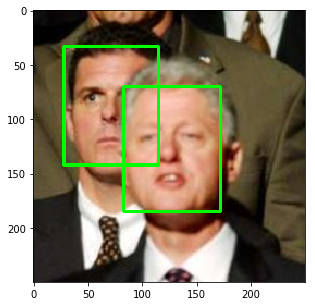

In [21]:
# 使用OpenCV讀入測試圖像
# 因為OpenCV讀進來的格式是BGR，所以要先轉換成RGB格式
bgr_image = cv2.imread(origin_face_image)
rgb_image = bgr_image[:,:,::-1] # 把BGR轉換成RGB

# 偵測人臉
bounding_boxes, _ = detect_face.detect_face(rgb_image, minsize, pnet, rnet, onet, threshold, factor)

# 複製原圖像
draw = bgr_image.copy()

# 被偵測到的臉部總數
faces_detected = len(bounding_boxes)

print('Total faces detected ：{}'.format(faces_detected))

# 每一個 bounding_box包括了（x1,y1,x2,y2,confidence score)：
# 　　左上角座標 (x1,y1)
#     右下角座標 (x2,y2)
#     信心分數 confidence score

# 每一個偵測出來的邊界框
for face_position in bounding_boxes:
    # 把資料由float轉成int
    face_position=face_position.astype(int)
    
    # 取出左上角座標 (x1,y1)與右下角座標 (x2,y2)
    # 由於有可能預測出來的臉在圖像的圖邊而導致座標值為負值
    # 進行的負值的偵測與修正
    x1 = face_position[0] if face_position[0] > 0 else 0
    y1 = face_position[1] if face_position[1] > 0 else 0
    x2 = face_position[2] if face_position[2] > 0 else 0
    y2 = face_position[3] if face_position[3] > 0 else 0
    
    # 在原圖像上畫上這些邊界框    
    cv2.rectangle(draw, (x1, y1), (x2, y2), (0, 255, 0), 2)

# 設定展示的大小
plt.figure(figsize=(10,5))

# 展示偵測出來的結果
plt.imshow(draw[:,:,::-1]) # 轉換成RGB來給matplotlib展示
plt.show()

以上的人臉圖像裡頭有兩個人臉被找出來,因此在圖像處理中要找到離圖像中心點比較接近的那一個來當成主要的人臉圖像並進行其它的前處理。

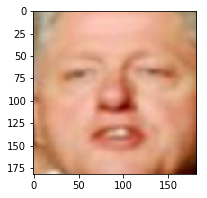

In [22]:
bgr_image = cv2.imread(aligned_face_image)
rgb_image = bgr_image[:,:,::-1] # 把BGR轉換成RGB

# 設定大小
plt.figure(figsize=(8,3))

# 偵測出來的結果
plt.imshow(rgb_image)
plt.show()